In [1]:
from bp import build_image_factor_graph, Loopy_BP, URW_BP, calculate_metrics

import numpy as np
import matplotlib.pyplot as plt


from PIL import Image, ImageOps


import os
import pickle as pkl

In [2]:
IMAGES = 'sideviews-cows2'

PATH_images = os.path.join('TUDarmstadt', 'PNGImages', IMAGES)
PATH_mask = os.path.join('TUDarmstadt', 'GTMasks', IMAGES)

# reduce the size of the image (otherwise sooooo long to build the factor graph -> implement without networkx ? in C/C++ ?)
REDUCTION_FACTOR = 2
NUM_PIXELS_INTENSITY = 64

images_names = os.listdir(PATH_images)
print('num images :',len(images_names))

# get the images and the masks, using only 64 possible values for pixel intensities
images_grey = []
images_grey_back_rd = [] # images with random values for the background... 

images_mask = []

for img in images_names:
    img_path  = os.path.join(PATH_images, img)
    mask_path = os.path.join(PATH_mask, img)

    im_frame = Image.open(img_path) # convert to grey scale
    im_mask = Image.open(mask_path)
    size = im_frame.size

    if REDUCTION_FACTOR > 1 :
        #
        im_frame = ImageOps.scale(im_frame, 1/REDUCTION_FACTOR)
        im_mask = ImageOps.scale(im_mask, 1/REDUCTION_FACTOR)

    im_frame = im_frame.convert('L')
    img_array = np.array(im_frame)
    mask_array = np.array(im_mask)

    # reduce the number of pixel intensities
    img_array = (img_array * ((NUM_PIXELS_INTENSITY - 1) / 255)).astype(np.uint8)

    images_grey.append(img_array)

    img_array_back_rd = img_array.copy()
    img_array_back_rd[~mask_array] = np.random.randint(0, NUM_PIXELS_INTENSITY, size=img_array_back_rd[~mask_array].shape)
    images_grey_back_rd.append(img_array_back_rd)

    images_mask.append(np.array(im_mask))


num images : 111


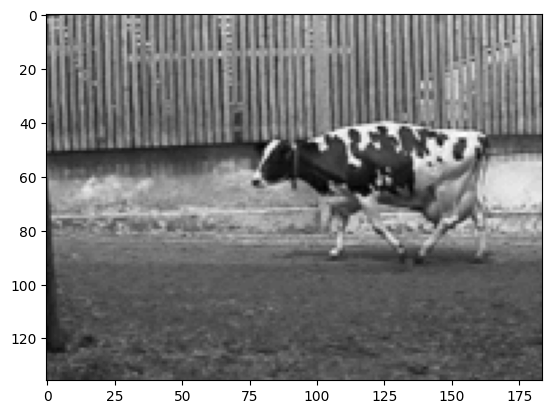

In [3]:
IMG_NUM = 45
images_names[IMG_NUM]
plt.imshow(images_grey[IMG_NUM], cmap='gray')
plt.show()

In [4]:
img = images_grey[IMG_NUM]
mask = images_mask[IMG_NUM]
img_shape = img.shape

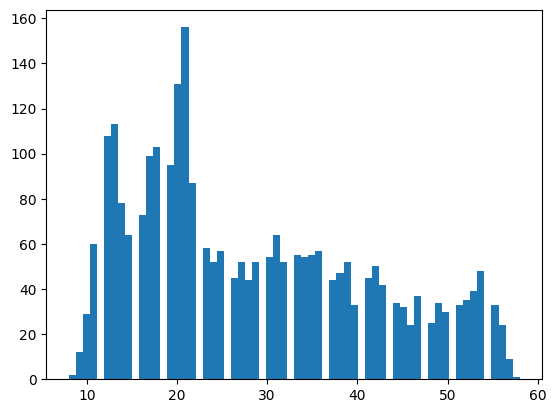

In [5]:
# histogram of the pixel intensities of the "segmented part" (cow, cars... NOT the all image)
plt.hist(img[mask], bins=NUM_PIXELS_INTENSITY)
plt.show()

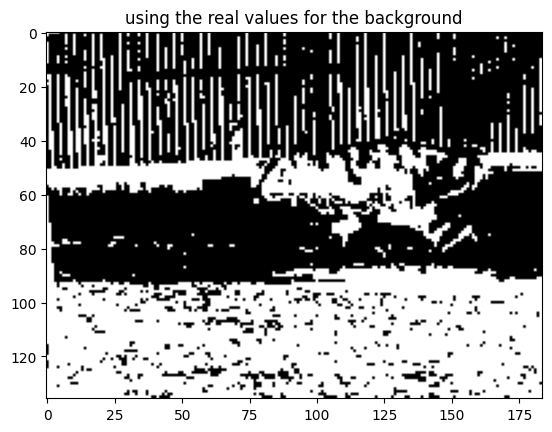

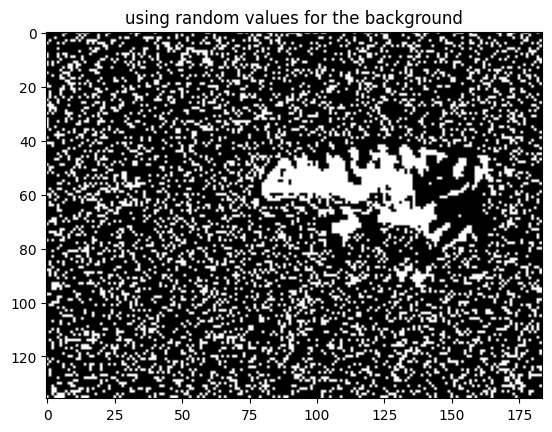

In [6]:
# just to see what it looks like just using the pixel intensities

im = images_grey[IMG_NUM]
im_back_rd = images_grey_back_rd[IMG_NUM]

# low, high = np.quantile(im[images_mask[IMG_NUM]], [0.1, 0.6]).astype(int)
low, high = 12, 26

def trans(im) :
    new_im = np.zeros(im.shape)
    for i, j in np.ndindex(im.shape):
        if im[i, j] < low or im[i, j] > high:
            new_im[i, j] = 0
        else:
            new_im[i, j] = 1
    return new_im


plt.imshow(trans(im), cmap='gray')
plt.title('using the real values for the background')
plt.show()

plt.imshow(trans(im_back_rd), cmap='gray')
plt.title('using random values for the background')
plt.show()

In [7]:
### build the factor distribs of the graph

# distrib for factor from pixel intensity
distrib_int_obs = np.zeros((64, 2)) + .1
distrib_int_obs[low:high, 1] = 1
distrib_int_obs[:low, 0] = 1
distrib_int_obs[high:, 0] = 1


# distrib for factor from class interaction
distrib_clc_neigh = np.array([[1, .1], [.1, 1]])


In [8]:
# build the factor graphs for the images (!! can be really long on high resolution images !!)
graph           = build_image_factor_graph(images_grey[IMG_NUM], distrib_int_obs, distrib_clc_neigh)
graph_back_rd   = build_image_factor_graph(images_grey_back_rd[IMG_NUM], distrib_int_obs, distrib_clc_neigh)

# Belief propagation (Loopy and URW)

In [9]:
N = 20

In [10]:
# beliefs propagation using URW_BP

model_URW = URW_BP(graph)
model_URW_back_rd = URW_BP(graph_back_rd)

beliefs_evol_URW = [] # to keep track of the beliefs evolution on one of the classes
beliefs_evol_URW_back_rd = []

for i in range(N) :
    print(i, end='\r')

    model_URW.loop()
    beliefs = np.array([model_URW.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_URW.append(beliefs[:, 1].reshape(img_shape))

    model_URW_back_rd.loop()
    beliefs = np.array([model_URW_back_rd.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_URW_back_rd.append(beliefs[:, 1].reshape(img_shape))

In [11]:
# beliefs propagation using loopy BP

model_loopy = Loopy_BP(graph)
model_loopy_back_rd = Loopy_BP(graph_back_rd)

beliefs_evol_loopy = [] # to keep track of the beliefs evolution on one of the classes
beliefs_evol_loopy_back_rd = []

for i in range(N) :
    print(i, end='\r')

    model_loopy.loop()
    beliefs = np.array([model_loopy.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_loopy.append(beliefs[:, 1].reshape(img_shape))

    model_loopy_back_rd.loop()
    beliefs = np.array([model_loopy_back_rd.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_loopy_back_rd.append(beliefs[:, 1].reshape(img_shape))

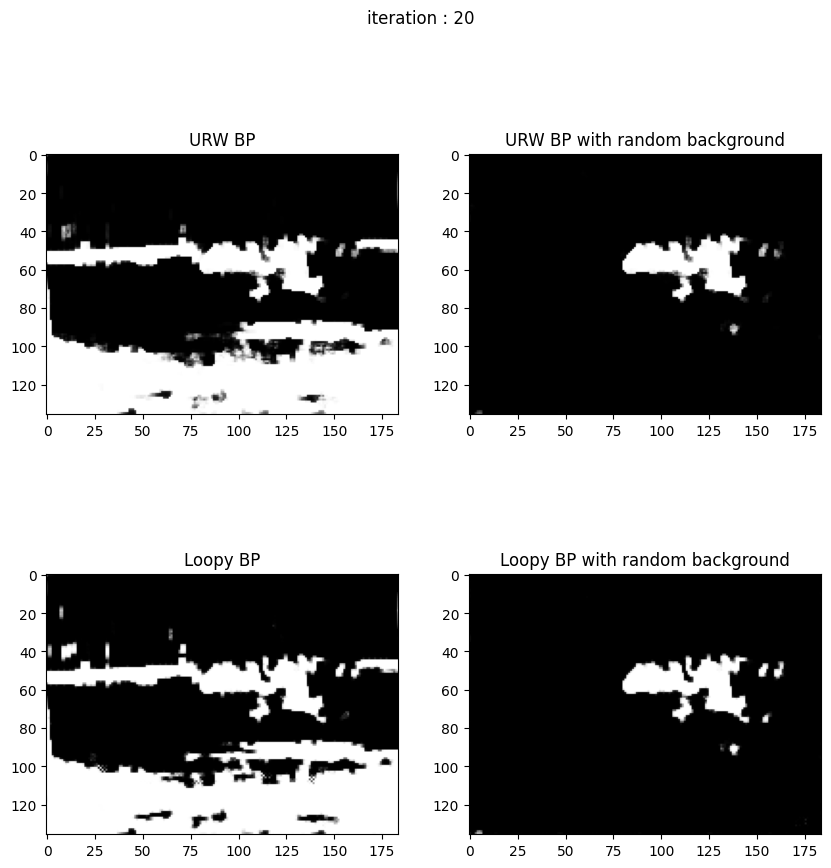

In [12]:
# build a little anim to visualise all that

from matplotlib.animation import FuncAnimation


# Create a figure and axis
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10, 10))
suptitle = fig.suptitle('iteration : 1')


# Initialize the imshow plot with the first frame of data
im00 = ax00.imshow(beliefs_evol_URW[0], cmap='grey', vmin=0, vmax=1)
ax00.set_title('URW BP')

im01 = ax01.imshow(beliefs_evol_URW_back_rd[0], cmap='grey', vmin=0, vmax=1)
ax01.set_title('URW BP with random background')

im10 = ax10.imshow(beliefs_evol_loopy[0], cmap='grey', vmin=0, vmax=1)
ax10.set_title('Loopy BP')

im11 = ax11.imshow(beliefs_evol_loopy_back_rd[0], cmap='grey', vmin=0, vmax=1)
ax11.set_title('Loopy BP with random background')

# Function to update the plot for each frame of the animation
def update(frame):
    suptitle.set_text('iteration : {}'.format(frame+1))
    im00.set_array(beliefs_evol_URW[frame])  
    im01.set_array(beliefs_evol_URW_back_rd[frame])  
    im10.set_array(beliefs_evol_loopy[frame])  
    im11.set_array(beliefs_evol_loopy_back_rd[frame])  
    return suptitle, im00, im01, im10, im11

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N))  


# Save the animation as a gif
save_to = os.path.join('res', '{}_red{}_Npxl{}__{}_{}.gif'.format(images_names[IMG_NUM], REDUCTION_FACTOR, NUM_PIXELS_INTENSITY, low, high))
ani.save(save_to, writer='pillow', fps=2)  # Adjust fps as needed
plt.show()


In [13]:
try :
    metrics_loopy = pkl.load(open(os.path.join('res', 'metrics_loopy__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'rb'))
    metrics_loopy_back_rd = pkl.load(open(os.path.join('res', 'metrics_loopy_back_rd__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'rb'))
    metrics_URW = pkl.load(open(os.path.join('res', 'metrics_URW__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'rb'))
    metrics_URW_back_rd = pkl.load(open(os.path.join('res', 'metrics_URW_back_rd__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'rb'))
except :
    metrics_loopy = []
    metrics_loopy_back_rd = []
    metrics_URW = []
    metrics_URW_back_rd = []


metrics_loopy.append(calculate_metrics(images_mask[IMG_NUM], beliefs_evol_loopy[-1]))
metrics_loopy_back_rd.append(calculate_metrics(images_mask[IMG_NUM], beliefs_evol_loopy_back_rd[-1]))
metrics_URW.append(calculate_metrics(images_mask[IMG_NUM], beliefs_evol_URW[-1]))
metrics_URW_back_rd.append(calculate_metrics(images_mask[IMG_NUM], beliefs_evol_URW_back_rd[-1]))

pkl.dump(metrics_loopy, open(os.path.join('res', 'metrics_loopy__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'wb'))
pkl.dump(metrics_loopy_back_rd, open(os.path.join('res', 'metrics_loopy_back_rd__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'wb'))
pkl.dump(metrics_URW, open(os.path.join('res', 'metrics_URW__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'wb'))
pkl.dump(metrics_URW_back_rd, open(os.path.join('res', 'metrics_URW_back_rd__red{}_Npxl{}.pkl'.format(REDUCTION_FACTOR, NUM_PIXELS_INTENSITY)), 'wb'))

In [14]:
print('Loopy BP - PA   :', np.mean(np.array(metrics_loopy)[:, 0]))
print('Loopy BP - IoU  :', np.mean(np.array(metrics_loopy)[:, 1]))
print('Loopy BP - dice :', np.mean(np.array(metrics_loopy)[:, 2]))
print()

print('Loopy BP rd back - PA   :', np.mean(np.array(metrics_loopy_back_rd)[:, 0]))
print('Loopy BP rd back - IoU  :', np.mean(np.array(metrics_loopy_back_rd)[:, 1]))
print('Loopy BP rd back - dice :', np.mean(np.array(metrics_loopy_back_rd)[:, 2]))
print()

print('URW BP - PA   :', np.mean(np.array(metrics_URW)[:, 0]))
print('URW BP - IoU  :', np.mean(np.array(metrics_URW)[:, 1]))
print('URW BP - dice :', np.mean(np.array(metrics_URW)[:, 2]))
print()

print('URW BP rd back - PA   :', np.mean(np.array(metrics_URW_back_rd)[:, 0]))
print('URW BP rd back - IoU  :', np.mean(np.array(metrics_URW_back_rd)[:, 1]))
print('URW BP rd back - dice :', np.mean(np.array(metrics_URW_back_rd)[:, 2]))

Loopy BP - PA   : 0.727080123846939
Loopy BP - IoU  : 0.3015949019922289
Loopy BP - dice : 0.41153233025911784

Loopy BP rd back - PA   : 0.9493810360316246
Loopy BP rd back - IoU  : 0.5860464596277258
Loopy BP rd back - dice : 0.732770107141833

URW BP - PA   : 0.7250440225395401
URW BP - IoU  : 0.29703833207875324
URW BP - dice : 0.4070911446937619

URW BP rd back - PA   : 0.9485102607829327
URW BP rd back - IoU  : 0.5770393041157839
URW BP rd back - dice : 0.7248042559801915
